In [35]:
import os
import csv
import gzip
from io import StringIO
from urllib.request import urlopen
from dateutil.parser import parse
from shapely import geometry
from pystac.extensions.eo import Band
from pystac import *
from shapely.geometry import Point, Polygon, mapping
import json
from datetime import datetime

os.chdir('/workspace/terradue.data/Test/Resources/LANDSAT8/')

## Function to read file from URL location

In [ ]:
url_test = 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/149/039/LC08_L1TP_149039_20170411_20170415_01_T1/index.html'

In [ ]:
def get_asset_url(scene, suffix):
    product_id = scene['productId']
    download_url = scene['download_url']
    asset_filename = '{}_{}'.format(product_id, suffix)
    return download_url.replace('index.html', asset_filename)

In [ ]:
scene_list = 'vendor_metadata/LC80330352013157LGN00_MTL.txt'

In [ ]:
# def get_scenes(scene_list):

scenes = None

if scene_list is not None:

    if os.path.exists(scene_list):
        print('read from file')
        #with open(scene_list, 'r') as file:
        #    content = file.read()

        scenes = list(csv.DictReader(open(scene_list)))

else:

    # Collection 1 data from URL
    url = 'https://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz'

    # Read and unzip the content
    response = urlopen(url)
    gunzip_response = gzip.GzipFile(fileobj=response)
    content = gunzip_response.read()
    
    # Read the scenes in as dictionaries
    scenes = list(csv.DictReader(StringIO(content.decode("utf-8"))))

scenes
# return scenes


In [ ]:
scenes

## Read Metadata MTL.txt

In [2]:
mtl_txt = 'vendor_metadata/LC80330352013157LGN00_MTL.txt'

mtl_dict = {} 

# creating dictionary 
with open(mtl_txt) as f: 
    
    for line in f.read().splitlines()[:-1]: # all lines but last one finishing in 'END'
        # reads each line, split command and description
        command, description = line.strip().split(' = ')
        
        # write to dict only actual metadata variables, not GROUP nor END_GROUP
        if command != 'GROUP' and command != 'END_GROUP': mtl_dict[command] = description.strip('"')

# # To write out to file (not necessary)
# out_file = open("test1.json", "w") 
# json.dump(mtl_dict, out_file, indent = 4, sort_keys = False) 
# out_file.close()

# mtl_dict

In [3]:
# Call the pystac help to see what's required
help(pystac.Item.__init__)

Help on function __init__ in module pystac.item:

__init__(self, id, geometry, bbox, datetime, properties, stac_extensions=None, href=None, collection=None, extra_fields=None)
    Initialize self.  See help(type(self)) for accurate signature.



## Get Identifier

In [4]:
mtl_file_info = {}
item_id = mtl_dict['LANDSAT_SCENE_ID']

mtl_file_info['id'] = item_id
mtl_file_info['ORIGIN'] = mtl_dict['ORIGIN']
mtl_file_info['REQUEST_ID'] = mtl_dict['REQUEST_ID']
mtl_file_info

{'id': 'LC80330352013157LGN00',
 'ORIGIN': 'Image courtesy of the U.S. Geological Survey',
 'REQUEST_ID': '0501306063923_00028'}

## Get Image Geometry and BBOX


In [5]:
p1 = Point(float(mtl_dict['CORNER_UL_LAT_PRODUCT']), float(mtl_dict['CORNER_UL_LON_PRODUCT'])); print(p1)
p2 = Point(float(mtl_dict['CORNER_UR_LAT_PRODUCT']), float(mtl_dict['CORNER_UR_LON_PRODUCT'])); print(p2)
p3 = Point(float(mtl_dict['CORNER_LR_LAT_PRODUCT']), float(mtl_dict['CORNER_LR_LON_PRODUCT'])); print(p3)
p4 = Point(float(mtl_dict['CORNER_LL_LAT_PRODUCT']), float(mtl_dict['CORNER_LL_LON_PRODUCT'])); print(p4)
p5 = Point(float(mtl_dict['CORNER_UL_LAT_PRODUCT']), float(mtl_dict['CORNER_UL_LON_PRODUCT'])); print(p5)

POINT (37.03264 -106.85401)
POINT (37.04494 -104.28029)
POINT (35.03275 -104.29837)
POINT (35.02132 -106.80746)
POINT (37.03264 -106.85401)


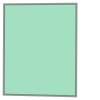

In [6]:
footprint = Polygon([p.x, p.y] for p in [p1, p2, p3, p4, p5])

footprint

In [7]:
bbox = list(footprint.bounds)

bbox

[35.02132, -106.85401, 37.04494, -104.28029]

In [8]:
geometry = mapping(footprint)

display(geometry)
# print(json.dumps(geometry, indent=2))

{'type': 'Polygon',
 'coordinates': (((37.03264, -106.85401),
   (37.04494, -104.28029),
   (35.03275, -104.29837),
   (35.02132, -106.80746),
   (37.03264, -106.85401)),)}

In [9]:
geometry['CORNER_UL_PROJECTION_X_PRODUCT'] = mtl_dict['CORNER_UL_PROJECTION_X_PRODUCT']
geometry['CORNER_UL_PROJECTION_Y_PRODUCT'] = mtl_dict['CORNER_UL_PROJECTION_Y_PRODUCT']
geometry['CORNER_UR_PROJECTION_X_PRODUCT'] = mtl_dict['CORNER_UR_PROJECTION_X_PRODUCT']
geometry['CORNER_UR_PROJECTION_Y_PRODUCT'] = mtl_dict['CORNER_UR_PROJECTION_Y_PRODUCT']
geometry['CORNER_LL_PROJECTION_X_PRODUCT'] = mtl_dict['CORNER_LL_PROJECTION_X_PRODUCT']
geometry['CORNER_LL_PROJECTION_Y_PRODUCT'] = mtl_dict['CORNER_LL_PROJECTION_Y_PRODUCT']
geometry['CORNER_LR_PROJECTION_X_PRODUCT'] = mtl_dict['CORNER_LR_PROJECTION_X_PRODUCT']
geometry['CORNER_LR_PROJECTION_Y_PRODUCT'] = mtl_dict['CORNER_LR_PROJECTION_Y_PRODUCT']

## Date and Time

In [10]:
date_and_time = {}
date_and_time['DATE_ACQUIRED'] = mtl_dict['DATE_ACQUIRED']
date_and_time['datetime'] = datetime.strptime(mtl_dict['FILE_DATE'], '%Y-%m-%dT%H:%M:%SZ')
date_and_time['SCENE_CENTER_TIME'] = mtl_dict['SCENE_CENTER_TIME']
date_and_time

{'DATE_ACQUIRED': '2013-06-06',
 'datetime': datetime.datetime(2013, 6, 6, 22, 9, 28),
 'SCENE_CENTER_TIME': '17:40:31.7519495Z'}

## Properties

In [11]:
properties = {}

### Projection Information

In [12]:
# proj = {}
properties['MAP_PROJECTION'] = mtl_dict['MAP_PROJECTION']
properties['DATUM'] = mtl_dict['DATUM']
properties['ELLIPSOID'] = mtl_dict['ELLIPSOID']
properties['UTM_ZONE'] = mtl_dict['UTM_ZONE']
properties['GRID_CELL_SIZE_PANCHROMATIC'] = mtl_dict['GRID_CELL_SIZE_PANCHROMATIC']
properties['GRID_CELL_SIZE_REFLECTIVE'] = mtl_dict['GRID_CELL_SIZE_REFLECTIVE']
properties['GRID_CELL_SIZE_THERMAL'] = mtl_dict['GRID_CELL_SIZE_THERMAL']
properties['ORIENTATION'] = mtl_dict['ORIENTATION']
properties['RESAMPLING_OPTION'] = mtl_dict['RESAMPLING_OPTION']
properties

{'MAP_PROJECTION': 'UTM',
 'DATUM': 'WGS84',
 'ELLIPSOID': 'WGS84',
 'UTM_ZONE': '13',
 'GRID_CELL_SIZE_PANCHROMATIC': '15.00',
 'GRID_CELL_SIZE_REFLECTIVE': '30.00',
 'GRID_CELL_SIZE_THERMAL': '30.00',
 'ORIENTATION': 'NORTH_UP',
 'RESAMPLING_OPTION': 'CUBIC_CONVOLUTION'}

### Mission Info

In [13]:
properties['platform'] = mtl_dict['SPACECRAFT_ID']
properties['instrument'] = mtl_dict['SENSOR_ID']
properties['WRS_PATH'] = mtl_dict['WRS_PATH']
properties['WRS_ROW'] = mtl_dict['WRS_ROW']
properties['NADIR'] = mtl_dict['NADIR_OFFNADIR']
properties['TARGET_WRS_PATH'] = mtl_dict['TARGET_WRS_PATH']
properties['TARGET_WRS_ROW'] = mtl_dict['TARGET_WRS_ROW']

properties['STATION_ID'] = mtl_dict['STATION_ID']
properties['PROCESSING_SOFTWARE_VERSION'] = mtl_dict['PROCESSING_SOFTWARE_VERSION']

### Format

In [14]:
properties['DATA_TYPE'] = mtl_dict['DATA_TYPE']
properties['ELEVATION_SOURCE'] = mtl_dict['ELEVATION_SOURCE']
properties['OUTPUT_FORMAT'] = mtl_dict['OUTPUT_FORMAT']

properties['PANCHROMATIC_LINES'] = mtl_dict['PANCHROMATIC_LINES']
properties['PANCHROMATIC_SAMPLES'] = mtl_dict['PANCHROMATIC_SAMPLES']
properties['REFLECTIVE_LINES'] = mtl_dict['REFLECTIVE_LINES']
properties['REFLECTIVE_SAMPLES'] = mtl_dict['REFLECTIVE_SAMPLES']
properties['THERMAL_LINES'] = mtl_dict['THERMAL_LINES']
properties['THERMAL_SAMPLES'] = mtl_dict['THERMAL_SAMPLES']

### Image Attributes

In [15]:
# attributes = {}
properties['CLOUD_COVER'] = mtl_dict['CLOUD_COVER']
properties['IMAGE_QUALITY_OLI'] = mtl_dict['IMAGE_QUALITY_OLI']
properties['IMAGE_QUALITY_TIRS'] = mtl_dict['IMAGE_QUALITY_TIRS']
properties['ROLL_ANGLE'] = mtl_dict['ROLL_ANGLE']
properties['SUN_AZIMUTH'] = mtl_dict['SUN_AZIMUTH']
properties['SUN_ELEVATION'] = mtl_dict['SUN_ELEVATION']
properties['EARTH_SUN_DISTANCE'] = mtl_dict['EARTH_SUN_DISTANCE']
properties['GROUND_CONTROL_POINTS_MODEL'] = mtl_dict['GROUND_CONTROL_POINTS_MODEL']
properties['GEOMETRIC_RMSE_MODEL'] = mtl_dict['GEOMETRIC_RMSE_MODEL']
properties['GEOMETRIC_RMSE_MODEL_Y'] = mtl_dict['GEOMETRIC_RMSE_MODEL_Y']
properties['GEOMETRIC_RMSE_MODEL_X'] = mtl_dict['GEOMETRIC_RMSE_MODEL_X']
properties['GROUND_CONTROL_POINTS_VERIFY'] = mtl_dict['GROUND_CONTROL_POINTS_VERIFY']
properties['GEOMETRIC_RMSE_VERIFY'] = mtl_dict['GEOMETRIC_RMSE_VERIFY']

### File names

In [16]:
properties['METADATA_FILE_NAME'] = mtl_dict['METADATA_FILE_NAME']
properties['BPF_NAME_OLI'] = mtl_dict['BPF_NAME_OLI']
properties['BPF_NAME_TIRS'] = mtl_dict['BPF_NAME_TIRS']
properties['CPF_NAME'] = mtl_dict['CPF_NAME']
properties['RLUT_FILE_NAME'] = mtl_dict['RLUT_FILE_NAME']

In [17]:
properties

{'MAP_PROJECTION': 'UTM',
 'DATUM': 'WGS84',
 'ELLIPSOID': 'WGS84',
 'UTM_ZONE': '13',
 'GRID_CELL_SIZE_PANCHROMATIC': '15.00',
 'GRID_CELL_SIZE_REFLECTIVE': '30.00',
 'GRID_CELL_SIZE_THERMAL': '30.00',
 'ORIENTATION': 'NORTH_UP',
 'RESAMPLING_OPTION': 'CUBIC_CONVOLUTION',
 'platform': 'LANDSAT_8',
 'instrument': 'OLI_TIRS',
 'WRS_PATH': '33',
 'WRS_ROW': '35',
 'NADIR': 'NADIR',
 'TARGET_WRS_PATH': '33',
 'TARGET_WRS_ROW': '35',
 'STATION_ID': 'LGN',
 'PROCESSING_SOFTWARE_VERSION': 'LPGS_2.2.2',
 'DATA_TYPE': 'L1T',
 'ELEVATION_SOURCE': 'GLS2000',
 'OUTPUT_FORMAT': 'GEOTIFF',
 'PANCHROMATIC_LINES': '14881',
 'PANCHROMATIC_SAMPLES': '15261',
 'REFLECTIVE_LINES': '7441',
 'REFLECTIVE_SAMPLES': '7631',
 'THERMAL_LINES': '7441',
 'THERMAL_SAMPLES': '7631',
 'CLOUD_COVER': '12.55',
 'IMAGE_QUALITY_OLI': '9',
 'IMAGE_QUALITY_TIRS': '9',
 'ROLL_ANGLE': '-0.001',
 'SUN_AZIMUTH': '121.50951213',
 'SUN_ELEVATION': '68.15928707',
 'EARTH_SUN_DISTANCE': '1.0148446',
 'GROUND_CONTROL_POINTS_MODEL'

## Create the Item

In [ ]:
# !pip install pystac[validation]

In [34]:
item = pystac.Item(id=item_id, 
                   geometry=mapping(footprint),
                   bbox=bbox,
                   datetime=date_and_time['datetime'],
                   properties=properties)
item.validate()

In [19]:
# Add Ground Sample Distance
item.common_metadata.gsd = 30.0

In [20]:
# Add the EO Extension 
item.ext.enable('eo')

In [21]:
# Add Cloud Cover
item.ext.eo.cloud_cover = float(mtl_dict['CLOUD_COVER'])
item.ext.eo.cloud_cover

12.55

### Add Assets - Band Info

In [22]:
from pystac.extensions.eo import Band

assets = {
    'B1':{
        'href':'./{}'.format(mtl_dict['FILE_NAME_BAND_1']),
        'type':'',
        'band':pystac.extensions.eo.Band.create(name="B1",
                                                common_name="coastal", 
                                                center_wavelength=0.44, 
                                                full_width_half_max=0.02),
        'gsd': item.common_metadata.gsd,
        'title':'Band 1 (coastal)',
        'RADIANCE_MAXIMUM_BAND_1':mtl_dict['RADIANCE_MAXIMUM_BAND_1'],
        'RADIANCE_MINIMUM_BAND_1':mtl_dict['RADIANCE_MINIMUM_BAND_1'],
        'REFLECTANCE_MAXIMUM_BAND_1':mtl_dict['REFLECTANCE_MAXIMUM_BAND_1'],
        'REFLECTANCE_MINIMUM_BAND_1':mtl_dict['REFLECTANCE_MINIMUM_BAND_1'],
        'QUANTIZE_CAL_MAX_BAND_1':mtl_dict['QUANTIZE_CAL_MAX_BAND_1'],
        'QUANTIZE_CAL_MIN_BAND_1':mtl_dict['QUANTIZE_CAL_MIN_BAND_1'],
        'RADIANCE_MULT_BAND_1':mtl_dict['RADIANCE_MULT_BAND_1'],
        'RADIANCE_ADD_BAND_1':mtl_dict['RADIANCE_ADD_BAND_1'],
        'REFLECTANCE_MULT_BAND_1':mtl_dict['REFLECTANCE_MULT_BAND_1'],
        'REFLECTANCE_ADD_BAND_1':mtl_dict['REFLECTANCE_ADD_BAND_1']
    },
    
    'B2':{
        'href':'./{}'.format(mtl_dict['FILE_NAME_BAND_2']),
        'type':'',
        'band':pystac.extensions.eo.Band.create(name="B2",
                                                common_name="blue", 
                                                center_wavelength=0.48, 
                                                full_width_half_max=0.06),
        'gsd': item.common_metadata.gsd,
        'title':'Band 2 (blue)',
        'RADIANCE_MAXIMUM_BAND_2':mtl_dict['RADIANCE_MAXIMUM_BAND_2'],
        'RADIANCE_MINIMUM_BAND_2':mtl_dict['RADIANCE_MINIMUM_BAND_2'],
        'REFLECTANCE_MAXIMUM_BAND_2':mtl_dict['REFLECTANCE_MAXIMUM_BAND_2'],
        'REFLECTANCE_MINIMUM_BAND_2':mtl_dict['REFLECTANCE_MINIMUM_BAND_2'],
        'QUANTIZE_CAL_MAX_BAND_2':mtl_dict['QUANTIZE_CAL_MAX_BAND_2'],
        'QUANTIZE_CAL_MIN_BAND_2':mtl_dict['QUANTIZE_CAL_MIN_BAND_2'],
        'RADIANCE_MULT_BAND_2':mtl_dict['RADIANCE_MULT_BAND_2'],
        'RADIANCE_ADD_BAND_2':mtl_dict['RADIANCE_ADD_BAND_2'],
        'REFLECTANCE_MULT_BAND_2':mtl_dict['REFLECTANCE_MULT_BAND_2'],
        'REFLECTANCE_ADD_BAND_2':mtl_dict['REFLECTANCE_ADD_BAND_2']
    },
    
    'B3':{
        'href':'./{}'.format(mtl_dict['FILE_NAME_BAND_3']),
        'type':'',
        'band':pystac.extensions.eo.Band.create(name="B3",
                                                common_name="green", 
                                                center_wavelength=0.56, 
                                                full_width_half_max=0.06),
        'gsd': item.common_metadata.gsd,
        'title':'Band 3 (green)',
        'RADIANCE_MAXIMUM_BAND_3':mtl_dict['RADIANCE_MAXIMUM_BAND_3'],
        'RADIANCE_MINIMUM_BAND_3':mtl_dict['RADIANCE_MINIMUM_BAND_3'],
        'REFLECTANCE_MAXIMUM_BAND_3':mtl_dict['REFLECTANCE_MAXIMUM_BAND_3'],
        'REFLECTANCE_MINIMUM_BAND_3':mtl_dict['REFLECTANCE_MINIMUM_BAND_3'],
        'QUANTIZE_CAL_MAX_BAND_3':mtl_dict['QUANTIZE_CAL_MAX_BAND_3'],
        'QUANTIZE_CAL_MIN_BAND_3':mtl_dict['QUANTIZE_CAL_MIN_BAND_3'],
        'RADIANCE_MULT_BAND_3':mtl_dict['RADIANCE_MULT_BAND_3'],
        'RADIANCE_ADD_BAND_3':mtl_dict['RADIANCE_ADD_BAND_3'],
        'REFLECTANCE_MULT_BAND_3':mtl_dict['REFLECTANCE_MULT_BAND_3'],
        'REFLECTANCE_ADD_BAND_3':mtl_dict['REFLECTANCE_ADD_BAND_3']
    },
    
    'B4':{
        'href':'./{}'.format(mtl_dict['FILE_NAME_BAND_4']),
        'type':'',
        'band':pystac.extensions.eo.Band.create(name="B4",
                                                common_name="red", 
                                                center_wavelength=0.65, 
                                                full_width_half_max=0.04),
        'gsd': item.common_metadata.gsd,
        'title':'Band 4 (red)',
        'RADIANCE_MAXIMUM_BAND_4':mtl_dict['RADIANCE_MAXIMUM_BAND_4'],
        'RADIANCE_MINIMUM_BAND_4':mtl_dict['RADIANCE_MINIMUM_BAND_4'],
        'REFLECTANCE_MAXIMUM_BAND_4':mtl_dict['REFLECTANCE_MAXIMUM_BAND_4'],
        'REFLECTANCE_MINIMUM_BAND_4':mtl_dict['REFLECTANCE_MINIMUM_BAND_4'],
        'QUANTIZE_CAL_MAX_BAND_4':mtl_dict['QUANTIZE_CAL_MAX_BAND_4'],
        'QUANTIZE_CAL_MIN_BAND_4':mtl_dict['QUANTIZE_CAL_MIN_BAND_4'],
        'RADIANCE_MULT_BAND_4':mtl_dict['RADIANCE_MULT_BAND_4'],
        'RADIANCE_ADD_BAND_4':mtl_dict['RADIANCE_ADD_BAND_4'],
        'REFLECTANCE_MULT_BAND_4':mtl_dict['REFLECTANCE_MULT_BAND_4'],
        'REFLECTANCE_ADD_BAND_4':mtl_dict['REFLECTANCE_ADD_BAND_4']
    },
    
    'B5':{
        'href':'./{}'.format(mtl_dict['FILE_NAME_BAND_5']),
        'type':'',
        'band':pystac.extensions.eo.Band.create(name="B5",
                                                common_name="nir", 
                                                center_wavelength=0.86, 
                                                full_width_half_max=0.03),
        'gsd': item.common_metadata.gsd,
        'title':'Band 5 (nir)',
        'RADIANCE_MAXIMUM_BAND_5':mtl_dict['RADIANCE_MAXIMUM_BAND_5'],
        'RADIANCE_MINIMUM_BAND_5':mtl_dict['RADIANCE_MINIMUM_BAND_5'],
        'REFLECTANCE_MAXIMUM_BAND_5':mtl_dict['REFLECTANCE_MAXIMUM_BAND_5'],
        'REFLECTANCE_MINIMUM_BAND_5':mtl_dict['REFLECTANCE_MINIMUM_BAND_5'],
        'QUANTIZE_CAL_MAX_BAND_5':mtl_dict['QUANTIZE_CAL_MAX_BAND_5'],
        'QUANTIZE_CAL_MIN_BAND_5':mtl_dict['QUANTIZE_CAL_MIN_BAND_5'],
        'RADIANCE_MULT_BAND_5':mtl_dict['RADIANCE_MULT_BAND_5'],
        'RADIANCE_ADD_BAND_5':mtl_dict['RADIANCE_ADD_BAND_5'],
        'REFLECTANCE_MULT_BAND_5':mtl_dict['REFLECTANCE_MULT_BAND_5'],
        'REFLECTANCE_ADD_BAND_5':mtl_dict['REFLECTANCE_ADD_BAND_5']
    },
    
    'B6':{
        'href':'./{}'.format(mtl_dict['FILE_NAME_BAND_6']),
        'type':'',
        'band':pystac.extensions.eo.Band.create(name="B6",
                                                common_name="swir16", 
                                                center_wavelength=1.6, 
                                                full_width_half_max=0.08),
        'gsd': item.common_metadata.gsd,
        'title':'Band 6 (swir16)',
        'RADIANCE_MAXIMUM_BAND_6':mtl_dict['RADIANCE_MAXIMUM_BAND_6'],
        'RADIANCE_MINIMUM_BAND_6':mtl_dict['RADIANCE_MINIMUM_BAND_6'],
        'REFLECTANCE_MAXIMUM_BAND_6':mtl_dict['REFLECTANCE_MAXIMUM_BAND_6'],
        'REFLECTANCE_MINIMUM_BAND_6':mtl_dict['REFLECTANCE_MINIMUM_BAND_6'],
        'QUANTIZE_CAL_MAX_BAND_6':mtl_dict['QUANTIZE_CAL_MAX_BAND_6'],
        'QUANTIZE_CAL_MIN_BAND_6':mtl_dict['QUANTIZE_CAL_MIN_BAND_6'],
        'RADIANCE_MULT_BAND_6':mtl_dict['RADIANCE_MULT_BAND_6'],
        'RADIANCE_ADD_BAND_6':mtl_dict['RADIANCE_ADD_BAND_6'],
        'REFLECTANCE_MULT_BAND_6':mtl_dict['REFLECTANCE_MULT_BAND_6'],
        'REFLECTANCE_ADD_BAND_6':mtl_dict['REFLECTANCE_ADD_BAND_6']
    },
    
    'B7':{
        'href':'./{}'.format(mtl_dict['FILE_NAME_BAND_7']),
        'type':'',
        'band':pystac.extensions.eo.Band.create(name="B7",
                                                common_name="swir22", 
                                                center_wavelength=2.2, 
                                                full_width_half_max=0.2),
        'gsd': item.common_metadata.gsd,
        'title':'Band 7 (swir22)',
        'RADIANCE_MAXIMUM_BAND_7':mtl_dict['RADIANCE_MAXIMUM_BAND_7'],
        'RADIANCE_MINIMUM_BAND_7':mtl_dict['RADIANCE_MINIMUM_BAND_7'],'REFLECTANCE_MAXIMUM_BAND_1':mtl_dict['REFLECTANCE_MAXIMUM_BAND_1'],
        'REFLECTANCE_MINIMUM_BAND_7':mtl_dict['REFLECTANCE_MINIMUM_BAND_7'],
        'QUANTIZE_CAL_MAX_BAND_7':mtl_dict['QUANTIZE_CAL_MAX_BAND_7'],
        'QUANTIZE_CAL_MIN_BAND_7':mtl_dict['QUANTIZE_CAL_MIN_BAND_7'],
        'RADIANCE_MULT_BAND_7':mtl_dict['RADIANCE_MULT_BAND_7'],
        'RADIANCE_ADD_BAND_7':mtl_dict['RADIANCE_ADD_BAND_7'],
        'REFLECTANCE_MULT_BAND_7':mtl_dict['REFLECTANCE_MULT_BAND_7'],
        'REFLECTANCE_ADD_BAND_7':mtl_dict['REFLECTANCE_ADD_BAND_7']
    },
    
    'B8':{
        'href':'./{}'.format(mtl_dict['FILE_NAME_BAND_8']),
        'type':'',
        'band':pystac.extensions.eo.Band.create(name="B8",
                                                common_name="pan", 
                                                center_wavelength=0.59, 
                                                full_width_half_max=0.18),
        'gsd': item.common_metadata.gsd,
        'title':'Band 8 (pan)',
        'RADIANCE_MAXIMUM_BAND_8':mtl_dict['RADIANCE_MAXIMUM_BAND_8'],
        'RADIANCE_MINIMUM_BAND_8':mtl_dict['RADIANCE_MINIMUM_BAND_8'],'REFLECTANCE_MAXIMUM_BAND_1':mtl_dict['REFLECTANCE_MAXIMUM_BAND_1'],
        'REFLECTANCE_MINIMUM_BAND_8':mtl_dict['REFLECTANCE_MINIMUM_BAND_8'],
        'QUANTIZE_CAL_MAX_BAND_8':mtl_dict['QUANTIZE_CAL_MAX_BAND_8'],
        'QUANTIZE_CAL_MIN_BAND_8':mtl_dict['QUANTIZE_CAL_MIN_BAND_8'],
        'RADIANCE_MULT_BAND_8':mtl_dict['RADIANCE_MULT_BAND_8'],
        'RADIANCE_ADD_BAND_8':mtl_dict['RADIANCE_ADD_BAND_8'],
        'REFLECTANCE_MULT_BAND_8':mtl_dict['REFLECTANCE_MULT_BAND_8'],
        'REFLECTANCE_ADD_BAND_8':mtl_dict['REFLECTANCE_ADD_BAND_8']
    },
    
    'B9':{
        'href':'./{}'.format(mtl_dict['FILE_NAME_BAND_9']),
        'type':'',
        'band':pystac.extensions.eo.Band.create(name="B9",
                                                common_name="cirrus", 
                                                center_wavelength=1.37, 
                                                full_width_half_max=0.02),
        'gsd': item.common_metadata.gsd,
        'title':'Band 9 (cirrus)',
        'RADIANCE_MAXIMUM_BAND_9':mtl_dict['RADIANCE_MAXIMUM_BAND_9'],
        'RADIANCE_MINIMUM_BAND_9':mtl_dict['RADIANCE_MINIMUM_BAND_9'],'REFLECTANCE_MAXIMUM_BAND_1':mtl_dict['REFLECTANCE_MAXIMUM_BAND_1'],
        'REFLECTANCE_MINIMUM_BAND_9':mtl_dict['REFLECTANCE_MINIMUM_BAND_9'],
        'QUANTIZE_CAL_MAX_BAND_9':mtl_dict['QUANTIZE_CAL_MAX_BAND_9'],
        'QUANTIZE_CAL_MIN_BAND_9':mtl_dict['QUANTIZE_CAL_MIN_BAND_9'],
        'RADIANCE_MULT_BAND_9':mtl_dict['RADIANCE_MULT_BAND_9'],
        'RADIANCE_ADD_BAND_9':mtl_dict['RADIANCE_ADD_BAND_9'],
        'REFLECTANCE_MULT_BAND_9':mtl_dict['REFLECTANCE_MULT_BAND_9'],
        'REFLECTANCE_ADD_BAND_9':mtl_dict['REFLECTANCE_ADD_BAND_9']
    },
    
    'B10':{
        'href':'./{}'.format(mtl_dict['FILE_NAME_BAND_10']),
        'type':'',
        'band':pystac.extensions.eo.Band.create(name="B10",
                                                common_name="lwir11", 
                                                center_wavelength=10.9, 
                                                full_width_half_max=0.8),
        'gsd': item.common_metadata.gsd,
        'title':'Band 10 (lwir11)',
        'RADIANCE_MAXIMUM_BAND_10':mtl_dict['RADIANCE_MAXIMUM_BAND_10'],
        'RADIANCE_MINIMUM_BAND_10':mtl_dict['RADIANCE_MINIMUM_BAND_10'],
        'QUANTIZE_CAL_MAX_BAND_10':mtl_dict['QUANTIZE_CAL_MAX_BAND_10'],
        'QUANTIZE_CAL_MIN_BAND_10':mtl_dict['QUANTIZE_CAL_MIN_BAND_10'],
        'RADIANCE_MULT_BAND_10':mtl_dict['RADIANCE_MULT_BAND_10'],
        'RADIANCE_ADD_BAND_10':mtl_dict['RADIANCE_ADD_BAND_10'],
        'K1_CONSTANT_BAND_10':mtl_dict['K1_CONSTANT_BAND_10'],
        'K2_CONSTANT_BAND_10':mtl_dict['K2_CONSTANT_BAND_10']
    },
    
    'B11':{
        'href':'./{}'.format(mtl_dict['FILE_NAME_BAND_11']),
        'type':'',
        'band':pystac.extensions.eo.Band.create(name="B11",
                                                common_name="lwir12", 
                                                center_wavelength=12, 
                                                full_width_half_max=1),
        'gsd': item.common_metadata.gsd,
        'title':'Band 11 (lwir12)',
        'RADIANCE_MAXIMUM_BAND_11':mtl_dict['RADIANCE_MAXIMUM_BAND_11'],
        'RADIANCE_MINIMUM_BAND_11':mtl_dict['RADIANCE_MINIMUM_BAND_11'],
        'QUANTIZE_CAL_MAX_BAND_11':mtl_dict['QUANTIZE_CAL_MAX_BAND_11'],
        'QUANTIZE_CAL_MIN_BAND_11':mtl_dict['QUANTIZE_CAL_MIN_BAND_11'],
        'RADIANCE_MULT_BAND_11':mtl_dict['RADIANCE_MULT_BAND_11'],
        'RADIANCE_ADD_BAND_11':mtl_dict['RADIANCE_ADD_BAND_11'],
        'K1_CONSTANT_BAND_11':mtl_dict['K1_CONSTANT_BAND_11'],
        'K2_CONSTANT_BAND_11':mtl_dict['K2_CONSTANT_BAND_11']
#     }, THESE TWO I SHOULD ADD TO THE OTHER_ASSETS AS THEY DONT HAVE THE 'band' KEY 
    
#     'BQA':{
#         'href':'./{}'.format(mtl_dict['FILE_NAME_BAND_QUALITY']),
#         'type':'',
#         'title':'Band QA'
#     },
    
#     'MTL':{
#         'href':mtl_dict['METADATA_FILE_NAME'],
#         'type':'',
#         'title':'Band QA (nir)'
    }

}
assets

{'B1': {'href': './LC80330352013157LGN00_B1.TIF',
  'type': '',
  'band': <Band name=B1>,
  'gsd': 30.0,
  'title': 'Band 1 (coastal)',
  'RADIANCE_MAXIMUM_BAND_1': '758.41290',
  'RADIANCE_MINIMUM_BAND_1': '-62.62999',
  'REFLECTANCE_MAXIMUM_BAND_1': '1.210700',
  'REFLECTANCE_MINIMUM_BAND_1': '-0.099980',
  'QUANTIZE_CAL_MAX_BAND_1': '65535',
  'QUANTIZE_CAL_MIN_BAND_1': '1',
  'RADIANCE_MULT_BAND_1': '1.2529E-02',
  'RADIANCE_ADD_BAND_1': '-62.64251',
  'REFLECTANCE_MULT_BAND_1': '2.0000E-05',
  'REFLECTANCE_ADD_BAND_1': '-0.100000'},
 'B2': {'href': './LC80330352013157LGN00_B2.TIF',
  'type': '',
  'band': <Band name=B2>,
  'gsd': 30.0,
  'title': 'Band 2 (blue)',
  'RADIANCE_MAXIMUM_BAND_2': '773.38159',
  'RADIANCE_MINIMUM_BAND_2': '-63.86610',
  'REFLECTANCE_MAXIMUM_BAND_2': '1.210700',
  'REFLECTANCE_MINIMUM_BAND_2': '-0.099980',
  'QUANTIZE_CAL_MAX_BAND_2': '65535',
  'QUANTIZE_CAL_MIN_BAND_2': '1',
  'RADIANCE_MULT_BAND_2': '1.2776E-02',
  'RADIANCE_ADD_BAND_2': '-63.87888',


In [ ]:
# # Other Assets

# for this I need the url of the L8 catalogue, so I can apply the function get_asset_url and retrieve relevant info

# def get_asset_url(scene, suffix):
#     product_id = scene['productId']
#     download_url = scene['download_url']
#     asset_filename = '{}_{}'.format(product_id, suffix)
#     return download_url.replace('index.html', asset_filename)

# def get_other_assets(scene):
#     return {
#             'thumbnail': {
#                 'href': get_asset_url(scene, 'thumb_large.jpg'),
#                 'media_type': pystac.MediaType.JPEG
#             },
#             'index': {
#                 'href': get_asset_url(scene, 'index.html'),
#                 'media_type': 'application/html'
#             },
#             'ANG': {
#                 'href': get_asset_url(scene, 'ANG.txt'),
#                 'media_type': 'text/plain'
#             },
#             'MTL': {
#                 'href': get_asset_url(scene, 'MTL.txt'),
#                 'media_type': 'text/plain'
#             },
#             'BQA': {
#                 'href': get_asset_url(scene, 'BQA.TIF'),
#                 'media_type': pystac.MediaType.GEOTIFF
#             }
#     }

In [23]:
# Add assets bands to the item
for band_id, band_info in assets.items():
    asset = pystac.Asset(href='...'+band_id,
                         media_type=MediaType.GEOTIFF,
                         roles=['data'])
    bands = [band_info['band']]
    item.ext.eo.set_bands(bands, asset)
    item.add_asset(band_id, asset)

# Add other assets
# MISSING
# for asset_id, asset_info in get_other_assets(scene).items():
#     item.add_asset(asset_id,
#                    pystac.Asset(href=asset_info['href'], media_type=asset_info['media_type']))

In [27]:
# print an example to dictionary
item.assets['B4'].to_dict()

{'href': '...B4',
 'type': 'image/tiff; application=geotiff',
 'eo:bands': [{'name': 'B4',
   'common_name': 'red',
   'center_wavelength': 0.65,
   'full_width_half_max': 0.04}],
 'roles': ['data']}

In [ ]:
# # Define a method to add all relevant assets to the item
# NEED THE FULL URL HERE!!!!!!!
# def add_assets(item, scene):
#     # Add bands
#     for band_id, band_info in landsat_band_info.items():
#         band_url = get_asset_url(scene, '{}.TIF'.format(band_id))
#         asset = pystac.Asset(href=band_url, media_type=pystac.MediaType.COG)
#         bands = [band_info['band']]
#         item.ext.eo.set_bands(bands, asset)
#         item.add_asset(band_id, asset)

#         # If this asset has a different GSD than the item, set it on the asset
#         if band_info['gsd'] != item.common_metadata.gsd:
#             item.common_metadata.set_gsd(band_info['gsd'], asset)

# #     # Add other assets
# #     for asset_id, asset_info in get_other_assets(scene).items():
# #         item.add_asset(asset_id,
# #                        pystac.Asset(href=asset_info['href'], media_type=asset_info['media_type']))

In [28]:
item.validate()

## Add Projection Information

In [29]:
# Get epsg code
def get_epsg(metadata, min_lat, max_lat):
    if 'UTM_ZONE' in metadata:
        center_lat = (min_lat + max_lat)/2.0
        return int(('326' if center_lat > 0 else '327') + metadata['UTM_ZONE'])
    else:
        return None

item.ext.enable('projection')
item.ext.projection.epsg = get_epsg(mtl_dict, item.bbox[1], item.bbox[3])
item.ext.projection.epsg

32713

### View Geometry Information

In [30]:
item.ext.enable('view')
item.ext.view.sun_azimuth = float(mtl_dict['SUN_AZIMUTH'])
item.ext.view.sun_elevation = float(mtl_dict['SUN_ELEVATION'])
item.properties

{'MAP_PROJECTION': 'UTM',
 'DATUM': 'WGS84',
 'ELLIPSOID': 'WGS84',
 'UTM_ZONE': '13',
 'GRID_CELL_SIZE_PANCHROMATIC': '15.00',
 'GRID_CELL_SIZE_REFLECTIVE': '30.00',
 'GRID_CELL_SIZE_THERMAL': '30.00',
 'ORIENTATION': 'NORTH_UP',
 'RESAMPLING_OPTION': 'CUBIC_CONVOLUTION',
 'platform': 'LANDSAT_8',
 'instrument': 'OLI_TIRS',
 'WRS_PATH': '33',
 'WRS_ROW': '35',
 'NADIR': 'NADIR',
 'TARGET_WRS_PATH': '33',
 'TARGET_WRS_ROW': '35',
 'STATION_ID': 'LGN',
 'PROCESSING_SOFTWARE_VERSION': 'LPGS_2.2.2',
 'DATA_TYPE': 'L1T',
 'ELEVATION_SOURCE': 'GLS2000',
 'OUTPUT_FORMAT': 'GEOTIFF',
 'PANCHROMATIC_LINES': '14881',
 'PANCHROMATIC_SAMPLES': '15261',
 'REFLECTIVE_LINES': '7441',
 'REFLECTIVE_SAMPLES': '7631',
 'THERMAL_LINES': '7441',
 'THERMAL_SAMPLES': '7631',
 'CLOUD_COVER': '12.55',
 'IMAGE_QUALITY_OLI': '9',
 'IMAGE_QUALITY_TIRS': '9',
 'ROLL_ANGLE': '-0.001',
 'SUN_AZIMUTH': '121.50951213',
 'SUN_ELEVATION': '68.15928707',
 'EARTH_SUN_DISTANCE': '1.0148446',
 'GROUND_CONTROL_POINTS_MODEL'

In [31]:
item.validate()

In [32]:
item.to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0-beta3',
 'id': 'LC80330352013157LGN00',
 'properties': {'MAP_PROJECTION': 'UTM',
  'DATUM': 'WGS84',
  'ELLIPSOID': 'WGS84',
  'UTM_ZONE': '13',
  'GRID_CELL_SIZE_PANCHROMATIC': '15.00',
  'GRID_CELL_SIZE_REFLECTIVE': '30.00',
  'GRID_CELL_SIZE_THERMAL': '30.00',
  'ORIENTATION': 'NORTH_UP',
  'RESAMPLING_OPTION': 'CUBIC_CONVOLUTION',
  'platform': 'LANDSAT_8',
  'instrument': 'OLI_TIRS',
  'WRS_PATH': '33',
  'WRS_ROW': '35',
  'NADIR': 'NADIR',
  'TARGET_WRS_PATH': '33',
  'TARGET_WRS_ROW': '35',
  'STATION_ID': 'LGN',
  'PROCESSING_SOFTWARE_VERSION': 'LPGS_2.2.2',
  'DATA_TYPE': 'L1T',
  'ELEVATION_SOURCE': 'GLS2000',
  'OUTPUT_FORMAT': 'GEOTIFF',
  'PANCHROMATIC_LINES': '14881',
  'PANCHROMATIC_SAMPLES': '15261',
  'REFLECTIVE_LINES': '7441',
  'REFLECTIVE_SAMPLES': '7631',
  'THERMAL_LINES': '7441',
  'THERMAL_SAMPLES': '7631',
  'CLOUD_COVER': '12.55',
  'IMAGE_QUALITY_OLI': '9',
  'IMAGE_QUALITY_TIRS': '9',
  'ROLL_ANGLE': '-0.001',
  

In [ ]:
'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/033/035/LC80330352013157LGN00/index.html

In [ ]:
write_file(item, include_self_link=True, dest_href=f'MetadataExtractorsTests_{item.id}.json')